In [1]:
import torch
import time

n = 1000
a = torch.ones(n)
b = torch.ones(n)
b.size()

torch.Size([1000])

In [2]:
import pandas as  pd
import numpy as np
import warnings 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
from scipy import stats
import pandas_profiling
from IPython import display
%matplotlib inline
warnings.filterwarnings('ignore')

### 线性回归

In [3]:
print(torch.__version__)

1.3.1


In [4]:
# 生成数据集
num_inputs = 2
num_examples = 1000

true_w = [7, 3.5]
true_b = 3.2

train_X = torch.randn(num_examples, num_inputs, dtype=torch.float32)
train_y = true_w[0] * train_X[:, 0] + true_w[1] * train_X[:, 1] + true_b
train_y += torch.tensor(np.random.normal(0, 0.01, size=train_y.size()),dtype=torch.float32)
train_y.size()

torch.Size([1000])

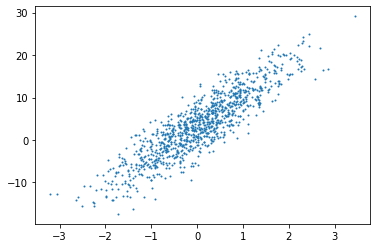

In [5]:
plt.scatter(train_X[:,0],train_y.numpy(),1)

In [6]:
import torch.utils.data as Data
BATCH_SIZE = 10
# 创建dataloader
torch_dataset = Data.TensorDataset(train_X, train_y)
# 把 dataset 放入 DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

In [7]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)
batch_size = 10

for X, y in data_iter(BATCH_SIZE, train_X, train_y):
    print(X, '\n', y)
    break

tensor([[ 3.0450e-01, -5.7754e-01],
        [-4.1908e-01,  9.4385e-01],
        [-8.1156e-01, -7.3385e-01],
        [ 5.8414e-04, -7.1829e-01],
        [ 1.6775e+00,  4.3164e-01],
        [-1.2180e-01,  6.1682e-01],
        [-1.0212e+00,  1.1124e+00],
        [ 8.0319e-01, -7.0935e-02],
        [-5.0832e-01,  1.0162e+00],
        [-2.5114e+00, -3.2888e-01]]) 
 tensor([  3.3106,   3.5785,  -5.0635,   0.7036,  16.4681,   4.4978,  -0.0515,
          8.5869,   3.2054, -15.5233])


In [8]:
# 初始化模型参数
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

# 定义模型
def linreg(X, w, b):
    return torch.mm(X, w) + b

# 损失函数
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

# 优化函数
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track

In [9]:
# super parameters init
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(BATCH_SIZE, train_X, train_y):
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(train_X, w, b), train_y)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.083394
epoch 2, loss 0.000264
epoch 3, loss 0.000050
epoch 4, loss 0.000049
epoch 5, loss 0.000049


In [10]:
w, true_w, b, true_b

(tensor([[7.0001],
         [3.4997]], requires_grad=True),
 [7, 3.5],
 tensor([3.1997], requires_grad=True),
 3.2)

### 使用pytorch实现线性回归

In [11]:
for X, y in loader:
    print(X, '\n', y)
    break

tensor([[-1.8751, -0.1286],
        [ 1.2170, -1.0364],
        [ 0.7822, -1.4562],
        [-0.5947,  0.4416],
        [ 0.0591, -0.5389],
        [ 0.8687,  0.4776],
        [-0.9141, -3.0403],
        [ 0.3356,  2.0735],
        [-0.4532, -0.9534],
        [-0.7270,  0.6272]]) 
 tensor([-10.3853,   8.0893,   3.5708,   0.5919,   1.7205,  10.9689, -13.8327,
         12.7841,  -3.3073,   0.3091])


In [12]:
class LLnet(torch.nn.Module):
    def __init__(self, n_feature):
        super(LLnet, self).__init__()      # call father function to init 
        self.linear = torch.nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
ll_net = LLnet(num_inputs)
print(ll_net)

LLnet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [13]:
# another way to set nn 模型

import torch.nn as nn
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

print(net)
print(net[0])

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [14]:
from torch.nn import init

init.normal_(ll_net.linear.weight, mean=0.0, std=0.01)
init.constant_(ll_net.linear.bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly

Parameter containing:
tensor([0.], requires_grad=True)

In [15]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD(ll_net.parameters(), lr = 0.03)

In [16]:
epoch = 5
for epoch in range(1, epoch+1):
    for X,y in loader:
        output = ll_net(X)
        l = loss(output,y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000232
epoch 2, loss: 0.000066
epoch 3, loss: 0.000073
epoch 4, loss: 0.000079
epoch 5, loss: 0.000045


In [18]:
dense = ll_net.linear
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[7, 3.5] tensor([[7.0000, 3.5001]])
3.2 tensor([3.1995])
